# Домашнее задание №2. "Рекомендации на основе содержания"
- ### Использовать dataset MovieLens
- ### Построить рекомендации (регрессия, предсказываем оценку) на фичах:
    TF-IDF на тегах и жанрах
    
    Средние оценки (+ median, variance, etc.) пользователя и фильма
- ### Оценить RMSE на тестовой выборке

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

%config InlineBackend.figure_format = 'svg'

%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [2]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [8]:
movie_genres = [change_string(g) for g in movies.genres.values]

In [9]:
tags.movieId.unique().shape

(1572,)

In [10]:
movies.movieId.unique().shape

(9742,)

In [11]:
ratings.movieId.unique().shape

(9724,)

## Возьмем только те фильмы, которые имеются во всех 3-ех датасетах сразу.

In [12]:
Ids = list(set(tags.movieId.unique()) & set(movies.movieId.unique()) & set(ratings.movieId.unique()))

In [13]:
for id in tqdm_notebook(tags.movieId):
    if id not in Ids:
        tags = tags[tags.movieId != id]
        
for id in tqdm_notebook(movies.movieId):
    if id not in Ids:
        movies = movies[movies.movieId != id]

for id in tqdm_notebook(ratings.movieId):
    if id not in Ids:
        ratings = ratings[ratings.movieId != id]

HBox(children=(IntProgress(value=0, max=3683), HTML(value='')))

HBox(children=(IntProgress(value=0, max=9742), HTML(value='')))

HBox(children=(IntProgress(value=0, max=100836), HTML(value='')))

### Проведем предпроцессинг данных для movies. Посчитаем CountVectorizer для жанров. А также в качестве фичи возьмем год выпуска фильма.

In [14]:
movie_genres = [change_string(g) for g in movies.genres.values]

In [15]:
del movies['genres']

movies['genres'] = movie_genres

In [16]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(movie_genres)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [17]:
for key, value in count_vect.vocabulary_.items():
    movies[key+'_genre'] = X_train_tfidf.toarray().T[value]

In [18]:
del movies['genres']

In [19]:
import re

def extract_year(row):
    match = re.search('\(\D*\d{4}\D*\)', row)
    if match:
        return int(re.search('\d{4}', match[0])[0])
    return 0

In [20]:
movies['year'] = movies['title'].apply(extract_year)

In [21]:
del movies['title']

### Проведем предпроцессинг данных для tags. Посчитаем CountVectorizer для тегов. А также в качестве фичи возьмем количество тегов.

In [22]:
tags['tag'] = tags['tag'].str.lower()
movie_tags = tags.groupby('movieId')[['tag']].agg(' '.join)
movie_tags.columns = ['tags']
tags = pd.merge(tags, movie_tags, left_on='movieId', right_index=True)

del tags['tag']
del tags['timestamp']
del tags['userId']

In [23]:
tags = tags.drop_duplicates(subset=['movieId'], keep='first')

In [24]:
tags.head()

,movieId,tags
0,60756,funny highly quotable will ferrell comedy funn...
3,89774,boxing story mma tom hardy
6,106782,drugs leonardo dicaprio martin scorsese stock ...
9,48516,way too long leonardo dicaprio suspense twist ...
10,431,al pacino gangster mafia


In [25]:
tags_list = list(tags.tags)
num_tags = []

for i in range(0, len(tags_list)):
    num_tags.append(len(tags_list[i].split(' ')))
tags['num_tags'] = num_tags

del tags['tags']

In [26]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(tags_list)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [27]:
for key, value in tqdm_notebook(count_vect.vocabulary_.items()):
    tags[key+'_tag'] = X_train_tfidf.toarray().T[value]

HBox(children=(IntProgress(value=0, max=1742), HTML(value='')))

### Посчитаем средний рейтинг фильма, а также количество рейтингов у этого фильма.

In [28]:
movies_rating_count = ratings.groupby('movieId', sort=False)['rating'].count()
movies_mean_rating = ratings.groupby('movieId', sort=False)[['rating']].mean()

### Соединим все в один датафрейм.

In [29]:
df = tags.merge(movies, on='movieId')

df = pd.merge(df, pd.DataFrame(movies_rating_count).rename(columns={'rating':'rating_count'}), 
                  left_on='movieId', right_index=True)

df = pd.merge(df, movies_mean_rating.rename(columns={'rating':'mean_rating'}), 
                  left_on='movieId', right_index=True)

### Наша целевая переменная - средний рейтинг фильма.

In [30]:
y = df['mean_rating']
X = df.drop(columns=['mean_rating'])
columns = X.columns

### Разделим выборку на тестовую и тренировочную.

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Нормализуем данные.

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_scaled, columns=columns)

In [33]:
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

### Обучим на оптимальных параметрах 3 регрессора: XGB, Lasso, RF

In [35]:
parameters = {
    'max_depth':range(1, 7, 1),
    'learning_rate':np.arange(0.1, 0.4, 0.1),
}

gsearch1 = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid = parameters,
            scoring='mean_squared_error',
            n_jobs=-1,
            iid=False,
            cv=10
)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_

[03:54:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'learning_rate': 0.2, 'max_depth': 4}

In [36]:
xgbreg = XGBRegressor(
        max_depth=gsearch1.best_params_['max_depth'],
        learning_rate=gsearch1.best_params_['learning_rate'],
        n_estimators=1000
)

xgbreg.fit(X_train, y_train)

y_test_predict_x = xgbreg.predict(X_test)

[03:54:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [37]:
np.sqrt(mean_squared_error(y_test, y_test_predict_x))

0.49308892300795365

In [38]:
parameters = {
    'alpha':np.arange(0, 1, 0.005),
}

gsearch2 = GridSearchCV(
            estimator=Lasso(),
            param_grid = parameters,
            scoring='mean_squared_error',
            n_jobs=-1,
            iid=False,
            cv=10
)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_

{'alpha': 0.02}

In [39]:
lasreg = Lasso(
        alpha=gsearch2.best_params_['alpha']
)

lasreg.fit(X_train, y_train)

y_test_predict_l = lasreg.predict(X_test)

In [40]:
np.sqrt(mean_squared_error(y_test, y_test_predict_l))

0.5257039831965725

In [41]:
parameters = {
    'max_depth': [1, 2, 3, 4, 5, 7, 9],
    'min_samples_split': np.arange(0.1, 0.6, 0.1),
    'min_samples_leaf': np.arange(0.1, 0.6, 0.1)
}

gsearch3 = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid = parameters,
            scoring='mean_squared_error',
            n_jobs=-1,
            iid=False,
            cv=10
)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_

{'max_depth': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}

In [42]:
rfreg = RandomForestRegressor(
        max_depth=gsearch3.best_params_['max_depth'],
        min_samples_split=gsearch3.best_params_['min_samples_split'],
        min_samples_leaf=gsearch3.best_params_['min_samples_leaf']
)
rfreg.fit(X_train, y_train)

y_test_predict_r = rfreg.predict(X_test)

In [43]:
np.sqrt(mean_squared_error(y_test, y_test_predict_r))

0.5333129053783272

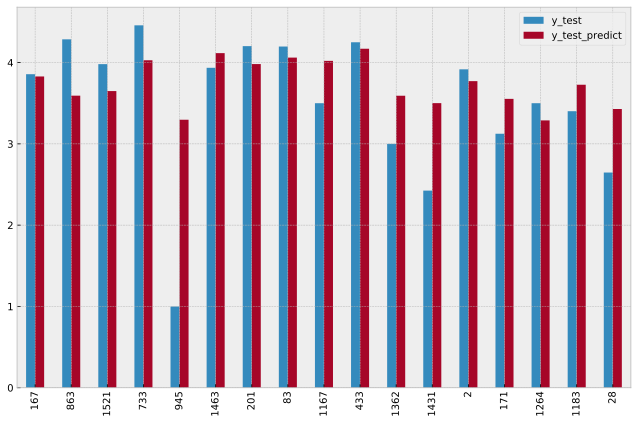

In [49]:
with plt.style.context('bmh'):
    pd.DataFrame({'y_test' : y_test, 'y_test_predict' : y_test_predict_x}).head(17).plot(kind='bar', figsize=(11,7))

### В целом, видно, что предсказание работает, кроме выброса у фильма 945.